# Assignment 1 - Data Exploration, Cleaning, and Modeling

### Objective
The goal of this assignment is hands-on practice with data exploration, cleaning, classification, and model selection. You will:

1. Conduct basic exploratory analysis of a dataset.
2. Develop linear and logistic regression models.
3. Interpret your models.
4. Partition your dataset and evaluate model classification performance.

---

### Dataset Information
The data in the accompanying file “dc_airbnb_file.csv” (posted on Canvas) contains data about 4936 Airbnb.com listings from the Washington, DC area. This is a small subset of the data that you will eventually use for the class project. The variables in this dataset should be self-explanatory but we have also provided a data dictionary.

Your task is to develop models to predict the target variable `high_booking_rate`, which labels whether a listing is popular (i.e. spends most of the time booked) or not.

Please answer the questions below clearly and concisely, providing tables or plots where applicable. Please submit a well-formatted jupyter notebook ***converted to an HTML file***, containing clear answers either in the form of text or code in the appropriate places to the questions.

To receive credit, your submitted code must work without any errors, its results should appear in the HTML file (i.e. make sure to run all cells before submission), and the entire document must be clear, concise and readable. You are free to use either Google Colab or Jupyter Notebook on your own computer.

---


In [82]:
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.formula.api as sm
import statsmodels.tools.eval_measures
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Import data

In [83]:
# If you are using Jupyter notebook, you should change this path to the location
# of the file in your computer.
# If you are using Google Colab, then you should eiter mount your google drive
# and change this path to the location of the file in your drive.
# or upload the file to the virtual machine and change the path accordingly.
airbnb =  pd.read_csv('./dc_airbnb_hw1.csv')
airbnb.columns

Index(['name', 'accommodates', 'bed_type', 'bedrooms', 'beds',
       'cancellation_policy', 'cleaning_fee', 'host_total_listings_count',
       'price', 'property_type', 'room_type', 'high_booking_rate'],
      dtype='object')

# 0:Example answer

What is the mean of the accommodates variable?

*ANSWER: The mean number of people that can be accommodated in a listing in this dataset is 3.522893.*

In [84]:
accommodates_mean = airbnb['accommodates'].mean()
print(f"The mean number of people that can be accommodated in a listing in this dataset is {accommodates_mean:.6f}.")

The mean number of people that can be accommodated in a listing in this dataset is 3.522893.


In [85]:
airbnb.head(5)

,name,accommodates,bed_type,bedrooms,beds,cancellation_policy,cleaning_fee,host_total_listings_count,price,property_type,room_type,high_booking_rate
0,Amazing renovated 1BR apt; 1 blk to Union Station,4,Real Bed,1.0,2.0,moderate,$45.00,1.0,$145.00,House,Entire home/apt,1
1,"High-End Apartment, in heart of DC",4,Real Bed,1.0,2.0,moderate,$35.00,4.0,$165.00,Apartment,Entire home/apt,1
2,Private Room&Bath on Capitol Hill,2,Real Bed,1.0,1.0,strict,$5.00,3.0,$70.00,House,Private room,1
3,---Lux Furnished 2-Bedroom DC Apartment!---,5,Real Bed,2.0,2.0,strict,$100.00,879.0,$199.00,Apartment,Entire home/apt,0
4,Two Bedroom House near the Capitol,5,Real Bed,2.0,2.0,strict,$50.00,1.0,$225.00,House,Entire home/apt,0


# 1: EDA and Data Cleaning

a)  Clean up and process some of the variables by doing the following (I recommend you do these in the order in which they are listed):
*   For `cancellation_policy`, group "strict" and "super_strict_30" into "strict"
*   Convert `cleaning_fee` and price into numbers
*   Replace NAs in `cleaning_fee` and price with 0
*   Replace NAs in other numerical variables with their mean

*ANSWER TO QUESTION 1a HERE:*

In [86]:
#For cancellation_policy, group "strict" and "super_strict_30" into "strict"
airbnb['cancellation_policy'] = airbnb['cancellation_policy'].replace({'super_strict_30': 'strict'})

#Convert cleaning_fee and price into numbers
airbnb['cleaning_fee'] = airbnb['cleaning_fee'].astype(str).replace({'\$': '', ',': ''}, regex=True).str.strip().astype(float)
airbnb['price'] = airbnb['price'].astype(str).replace({'\$': '', ',': ''}, regex=True).str.strip().astype(float)

#Replace NAs in cleaning_fee and price with 0
airbnb['cleaning_fee'] = airbnb['cleaning_fee'].fillna(0)
airbnb['price'] = airbnb['price'].fillna(0)

#Replace NAs in other numerical variables with their mean
airbnb.fillna({
    'accommodates': airbnb['accommodates'].mean(),
    'bedrooms': airbnb['bedrooms'].mean(),
    'beds': airbnb['beds'].mean(),
    'host_total_listings_count': airbnb['host_total_listings_count'].mean(),
    'high_booking_rate': airbnb['high_booking_rate'].mean()
}, inplace=True)

In [87]:
print(airbnb.isnull().sum())

name                         3
accommodates                 0
bed_type                     0
bedrooms                     0
beds                         0
cancellation_policy          0
cleaning_fee                 0
host_total_listings_count    0
price                        0
property_type                0
room_type                    0
high_booking_rate            0
dtype: int64


b)  Create five new variables. Make sure to convert non-numeric variables to categorical type:


*   `price_per_person` is the nightly price per accommodates

*   `has_cleaning_fee` is YES if there is a cleaning fee, and NO otherwise

*   `bed_category` is "bed" if the bed_type is Real Bed and "other" otherwise

*   `property_category` has the following values:

    *   apartment if `property_type` is Apartment, Serviced apartment, Loft.
    *   hotel if `property_type` is Bed & Breakfast, Boutique hotel, Hostel.
    *   condo if `property_type` is Townhouse, Condominium.
    *   house if `property_type` is Bungalow, House.
    *   other, otherwise

-   ppp_ind is 1 if the `price_per_person` is greater than the median for the `property_category`, and 0 otherwise
  

*ANSWER TO QUESTION 1b HERE:*

In [88]:
#price_per_person
airbnb['price_per_person'] = airbnb['price'] / airbnb['accommodates']

#has_cleaning_fee
airbnb['has_cleaning_fee'] = airbnb['cleaning_fee'].apply(lambda x: 'YES' if x > 0 else 'NO')

#bed_category
airbnb['bed_category'] = airbnb['bed_type'].apply(lambda x: 'bed' if x == 'Real Bed' else 'other')

#property_category
def property(property_type):
    if property_type in ['Apartment', 'Serviced apartment', 'Loft']:
        return 'apartment'
    elif property_type in ['Bed & Breakfast', 'Boutique hotel', 'Hostel']:
        return 'hotel'
    elif property_type in ['Townhouse', 'Condominium']:
        return 'condo'
    elif property_type in ['Bungalow', 'House']:
        return 'house'
    else:
        return 'other'

airbnb['property_category'] = airbnb['property_type'].apply(property)

#ppp_ind
median_ppp = airbnb.groupby('property_category')['price_per_person'].transform('median')
airbnb['ppp_ind'] = (airbnb['price_per_person'] > median_ppp).astype(int)

# Convert non-numeric variables to categorical type
categorical_col = ['has_cleaning_fee', 'bed_category', 'property_category']
airbnb[categorical_col] = airbnb[categorical_col].astype('category')

c) Convert the following character variables to categorical:

* bed_type
* cancellation_policy
* room_type

*ANSWER TO QUESTION 1c HERE:*

In [89]:
categorical_col = ['bed_type', 'cancellation_policy', 'room_type']
airbnb[categorical_col] = airbnb[categorical_col].astype('category')

airbnb.dtypes

,0
name,object
accommodates,int64
bed_type,category
bedrooms,float64
beds,float64
cancellation_policy,category
cleaning_fee,float64
host_total_listings_count,float64
price,float64
property_type,object


d) Construct boxplots of `price_per_person` and `log(price_per_person)`, grouped by `high_booking_rate`. Does it appear that there is a relationship between `price_per_person` and `high_booking_rate`? Explain

*ANSWER TO QUESTION 1d HERE:*

<ipython-input-90-1ce160b3e24a>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='high_booking_rate', y='price_per_person', data=airbnb, palette='viridis')
<ipython-input-90-1ce160b3e24a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='high_booking_rate', y='log_price_per_person', data=airbnb, palette='viridis')


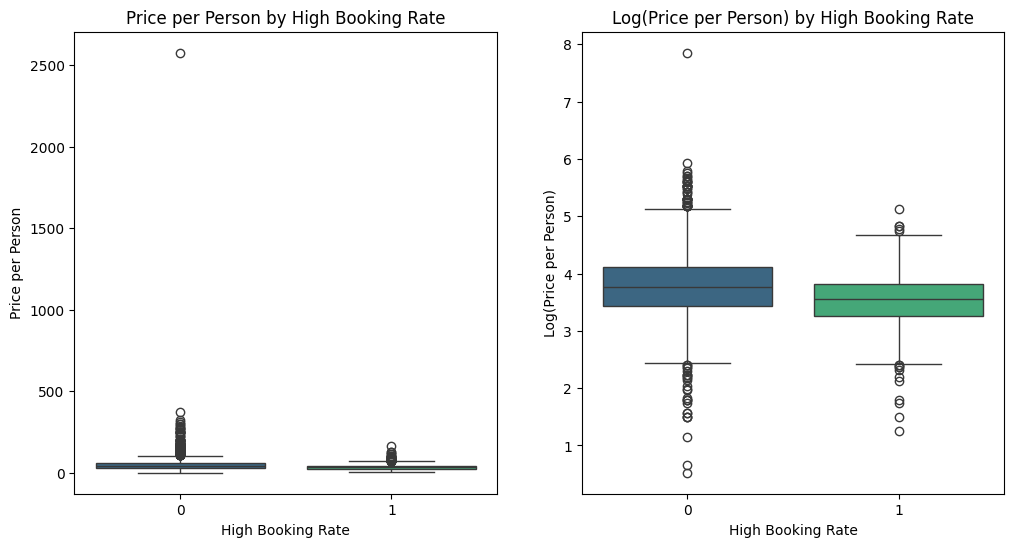

In [90]:
airbnb['log_price_per_person'] = np.log1p(airbnb['price_per_person'])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='high_booking_rate', y='price_per_person', data=airbnb, palette='viridis')
plt.title('Price per Person by High Booking Rate')
plt.xlabel('High Booking Rate')
plt.ylabel('Price per Person')

plt.subplot(1, 2, 2)
sns.boxplot(x='high_booking_rate', y='log_price_per_person', data=airbnb, palette='viridis')
plt.title('Log(Price per Person) by High Booking Rate')
plt.xlabel('High Booking Rate')
plt.ylabel('Log(Price per Person)')

plt.show()

There is a negative relationship between price_per_person and high_booking_rate as lower prices per person increase the likelihood of achieving a high booking rate. We can make this conclusion as listings with high booking rates are generally concentrated at lower log prices.

e) Construct a two-way table of `high_booking_rate` by `property_category`. Do any property categories show significantly higher or lower booking rates?

*ANSWER TO QUESTION 1e HERE:*

In [58]:
table = pd.crosstab(airbnb['high_booking_rate'], airbnb['property_category'])
table

property_category,apartment,condo,hotel,house,other
high_booking_rate,,,,,
0,2013,387,50,1198,50
1,672,171,12,363,20


Condos have the highest booking rate which indicates strong demand. Whereas, hotels have the lowest booking rate. These insights highlight opportunities to focus on promoting condos.

# 2: Linear Regression

a) Train a linear regression to predict `high_booking_rate` using the variables listed below. Report the R².

*   cancellation_policy
*   cleaning_fee
*   price_per_person
*   ppp_ind
*   has_cleaning_fee
*   accommodates
*   bed_category
*   bedrooms
*   beds
*   host_total_listings_count
*   property_category

*ANSWER TO QUESTION 2a HERE:*

In [62]:
lin_model = sm.ols('high_booking_rate ~ cancellation_policy + cleaning_fee + price_per_person + ppp_ind + has_cleaning_fee + accommodates + bed_category + bedrooms + beds + host_total_listings_count + property_category', data=airbnb).fit()
print(lin_model.summary())

                            OLS Regression Results                            
Dep. Variable:      high_booking_rate   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     28.13
Date:                Mon, 24 Feb 2025   Prob (F-statistic):           5.25e-77
Time:                        02:48:46   Log-Likelihood:                -2674.8
No. Observations:                4936   AIC:                             5382.
Df Residuals:                    4920   BIC:                             5486.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [63]:
r_sq = lin_model.rsquared
print(f"Linear Regression R² value: {r_sq:.4f}")

Linear Regression R² value: 0.0790


b) What is the predicted value of `high_booking_rate` for a listing with the following characteristics, and how would you interpret this prediction?

New Listing:

*   cancellation_policy = super_strict_30
*   cleaning_fee = \$30
*   price = \$200
*   accommodates = 4
*   bed_type = Real Bed
*   bedrooms = 3
*   beds = 4
*   host_total_listings_count = 1
*   property_type = townhouse

Hint: you will have to do the same processing on this new listing as you applied to the main dataset, but feel free to do it by hand before importing the data rather than using the same code as before.

*ANSWER TO QUESTION 2b HERE:*

In [66]:
 listing = pd.DataFrame([{
    'cancellation_policy': 'strict', 'cleaning_fee': 30, 'price_per_person': 200 / 4, 'ppp_ind': 1, 'has_cleaning_fee': 'YES', 'accommodates': 4, 'bed_category': 'bed',
    'bedrooms': 3, 'beds': 4, 'host_total_listings_count': 1, 'property_category': 'condo' }])

listing_high_booking_rate = lin_model.predict(listing)
print(f"Predicted value of high_booking_rate for the given listing: {listing_high_booking_rate.iloc[0]:.4f}")

Predicted value of high_booking_rate for the given listing: 0.2979


The output indicates that this listing is expected to be booked about 30% of the time, suggesting moderate popularity. The price per person of $50 might be higher than optimal, given the model's indication that lower prices improve booking rates. Additionally, the strict cancellation policy might be negativly impacting the rate. However, being a condo is a positive factor, as condos generally show higher booking rates.

c) Do you have any reservations about this predicted `high_booking_rate`? That is, would you feel sufficiently comfortable with this prediction in order to take some business action based on it? Why or why not?

*ANSWER TO QUESTION 2c HERE:*

The low R-squared value of just 0.079 indicates poor predictive strength. This suggests that key factors affecting booking rates may be missing from the model, making it unreliable for guiding business decisions.

# 3: Logistic Regression

a) Train a logistic regression model using the same variables as in 2a. Report the AIC.

*ANSWER TO QUESTION 3a HERE:*

In [ ]:
logit_model = sm.logit('high_booking_rate ~ cancellation_policy + cleaning_fee + price_per_person + ppp_ind + has_cleaning_fee + accommodates + bed_category + bedrooms + beds + host_total_listings_count + property_category', data=airbnb).fit()
print(logit_model.summary2())

Optimization terminated successfully.
         Current function value: 0.514845
         Iterations 9
                                Results: Logit
Model:                   Logit                 Method:               MLE       
Dependent Variable:      high_booking_rate     Pseudo R-squared:     0.086     
Date:                    2025-02-24 00:51      AIC:                  5114.5537 
No. Observations:        4936                  BIC:                  5218.6227 
Df Model:                15                    Log-Likelihood:       -2541.3   
Df Residuals:            4920                  LL-Null:              -2780.1   
Converged:               1.0000                LLR p-value:          3.0869e-92
No. Iterations:          9.0000                Scale:                1.0000    
-------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------

Logistic Regression AIC value: 5114.5537

b) What is the coefficient for `price_per_person`? Provide a precise (numerical) interpretation of the coefficient in plain English.

*ANSWER TO QUESTION 3b HERE:*

A coefficient for price_per_person is -0.0191 i.e. for each $1 increase in price_per_person, the log-odds of a listing being highly booked decrease by 0.0191, with all other variables constant.

For each $1 increase in price per person, the odds of a listing being highly booked decrease by approximately 1.9%.

c) What is the coefficient for `property_category = condo`? Provide a precise (numerical) interpretation of this coefficient in plain English.

*ANSWER TO QUESTION 3c HERE:*

A coefficient for property_category = condo is 0.3494 i.e. if a listing's property type is condo, the log-odds of it being highly booked increase by 0.3494, with all other variables constant.

Listings categorised as condos have approx 1.42 times higher odds of being highly booked compared to the apartments (baseline in our model), assuming all other features remain the same.

d) Compute the predicted probability that the same listing as in 2b will have `high_booking_rate = 1`.

*ANSWER TO QUESTION 3d HERE:*

In [67]:
 listing = pd.DataFrame([{
    'cancellation_policy': 'strict', 'cleaning_fee': 30, 'price_per_person': 200 / 4, 'ppp_ind': 1, 'has_cleaning_fee': 'YES', 'accommodates': 4, 'bed_category': 'bed',
    'bedrooms': 3, 'beds': 4, 'host_total_listings_count': 1, 'property_category': 'condo' }])

listing_high_booking_rate = logit_model.predict(new_listing)
print(f"Predicted value of high_booking_rate for the given listing: {listing_high_booking_rate.iloc[0]:.4f}")

Predicted value of high_booking_rate for the given listing: 0.3300


e) If you were to pick one model to use for the purposes of explaining the relationship between the features and the target variable, which would it be, and why?

*ANSWER TO QUESTION 3e HERE:*

I would choose the logistic regression model because it provides a clear probability interpretation for the high_booking_rate. The predicted value of 0.3300 offers a direct understanding of the likelihood of high bookings, and the model's coefficients help explain how features influence booking odds, making it more insightful for decision making.

# 4: Classification and Evaluation

a) Split the data into 70% training and 30% validation/test sets, retrain the logistic and linear models on the training data, and report R² (linear) and AIC (logistic and linear).

Before splitting the data, set the random seed to 12345 using the code below. This ensure everybody gets the same random split.
```
import random
import numpy as np
random.seed(12345)
np.random.seed(12345)
```



*ANSWER TO QUESTION 4a HERE:*

In [68]:
import random
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf

random.seed(12345)
np.random.seed(12345)

train_data, test_data = train_test_split(airbnb, test_size=0.3, random_state=12345)

#Linear regression model
lin_model = smf.ols(
    'high_booking_rate ~ cancellation_policy + cleaning_fee + price_per_person + ppp_ind + has_cleaning_fee + accommodates + bed_category + bedrooms + beds + host_total_listings_count + property_category',
    data=train_data
).fit()

#logistic regression model
logit_model = smf.logit(
    'high_booking_rate ~ cancellation_policy + cleaning_fee + price_per_person + ppp_ind + has_cleaning_fee + accommodates + bed_category + bedrooms + beds + host_total_listings_count + property_category',
    data=train_data
).fit()

Optimization terminated successfully.
         Current function value: 0.507731
         Iterations 10


In [73]:
#R² and AIC
lin_r_sq = lin_model.rsquared
lin_aic = lin_model.aic

print("Linear Regression Model:")
print(f"R square: {lin_r_sq:.4f}")
print(f"AIC: {lin_aic:.4f}")

logit_aic = logit_model.aic

print("\nLogistic Regression Model:")
print(f"AIC: {logit_aic:.4f}")

Linear Regression Model:
R square: 0.0768
AIC: 3706.7739

Logistic Regression Model:
AIC: 3540.4187


b)  Compute the RMSE in the training and validation/test sets for the linear model (do not do the classifications, just use the predicted score). Which RMSE is higher (training or validation), and does this make sense? Why or why not?

*ANSWER TO QUESTION 4b HERE:*

In [74]:
# model predictions
train_pred_lin_model = lin_model.predict(train_data)
test_pred_lin_model = lin_model.predict(test_data)
train_pred_logit_model = logit_model.predict(train_data)
test_pred_logit_model = logit_model.predict(test_data)

# RMSE
train_rmse_lin_model = np.sqrt(mean_squared_error(train_data['high_booking_rate'], train_pred_lin_model))
test_rmse_lin_model = np.sqrt(mean_squared_error(test_data['high_booking_rate'], test_pred_lin_model))
train_rmse_log = np.sqrt(mean_squared_error(train_data['high_booking_rate'], train_pred_logit_model))
test_rmse_log = np.sqrt(mean_squared_error(test_data['high_booking_rate'], test_pred_logit_model))

print("Linear regression model:")
print(f"Train RMSE: {train_rmse_lin_model:.4f}")
print(f"Test RMSE: {test_rmse_lin_model:.4f}")

print("\nLogistic regression model:")
print(f"Train RMSE: {train_rmse_log:.4f}")
print(f"Test RMSE: {test_rmse_log:.4f}")

Linear regression model:
Train RMSE: 0.4118
Test RMSE: 0.4268

Logistic regression model:
Train RMSE: 0.4103
Test RMSE: 0.4251


The test RMSE is slightly higher than the train RMSE for both models, with 0.4268 vs. 0.4118 for linear regression and 0.4251 vs. 0.4103 for logistic regression. This small increase in RMSE on the test set is expected as models often perform slightly worse on unseen data.

c) For each model (both the linear and logistic regression models learned on the training data), display the confusion matrix resulting from classification on the validation/test data using a cutoff of 0.5.

*ANSWER TO QUESTION 4c HERE:*

In [76]:
test_pred_lin_classify = (test_pred_lin_model >= 0.5).astype(int)
test_pred_log_classify = (test_pred_logit_model >= 0.5).astype(int)

# Confusion matrix
cm_lin = confusion_matrix(test_data['high_booking_rate'], test_pred_lin_classify)
cm_log = confusion_matrix(test_data['high_booking_rate'], test_pred_log_classify)

print("Confusion Matrix:")
print("\nLinear Regression Model:")
print(cm_lin)
print("\nLogistic Regression Model:")
print(cm_log)

Confusion Matrix:

Linear Regression Model:
[[1071   10]
 [ 393    7]]

Logistic Regression Model:
[[1057   24]
 [ 380   20]]


d) Report the accuracy, TPR, and FPR using the two confusion matrices in 4c. Which model is the most accurate?

*ANSWER TO QUESTION 4d HERE:*

In [80]:
tn_lin, fp_lin, fn_lin, tp_lin = cm_lin.ravel()
tn_log, fp_log, fn_log, tp_log = cm_log.ravel()

# Accuracy, TPR, and FPR calculation
accuracy_lin = accuracy_score(test_data['high_booking_rate'], test_pred_lin_classify)
tpr_lin = tp_lin / (tp_lin + fn_lin)
fpr_lin = fp_lin / (fp_lin + tn_lin)
accuracy_log = accuracy_score(test_data['high_booking_rate'], test_pred_log_classify)
tpr_log = tp_log / (tp_log + fn_log)
fpr_log = fp_log / (fp_log + tn_log)

print("Linear Regression Model:")
print("Accuracy:")
print(accuracy_lin)
print("TPR:")
print(tpr_lin)
print("FPR:")
print(fpr_lin)

print("\nLogistic Regression Model:")
print("Accuracy:")
print(accuracy_log)
print("TPR:")
print(tpr_log)
print("FPR:")
print(fpr_log)

Linear Regression Model:
Accuracy:
0.7278865631330182
TPR:
0.0175
FPR:
0.009250693802035153

Logistic Regression Model:
Accuracy:
0.7272113436866982
TPR:
0.05
FPR:
0.022201665124884366


The linear regression model has a slightly higher accuracy (0.7279) compared to the logistic regression model (0.7272), making it technically more accurate. However, the logistic model offers a significantly higher TPR (0.0500 vs. 0.0175), meaning it captures more true positives. We can conclude that Linear regression model is overall more accurate.

e) For the more accurate model, compute the accuracy, TPR, and FPR using cutoffs of .4 , .5 and .6 on the validation/test data. Which cutoff has the highest accuracy, highest TPR, and highest FPR?

*ANSWER TO QUESTION 4e HERE:*

In [92]:
cutoffs = [0.4, 0.5, 0.6]
results = {}

# accuracy, TPR, and FPR for each cutoff
for cutoff in cutoffs:
    test_pred_lin_classify = (test_pred_lin_model >= cutoff).astype(int)
    cm = confusion_matrix(test_data['high_booking_rate'], test_pred_lin_classify)
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(test_data['high_booking_rate'], test_pred_lin_classify)
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    results[f"Cutoff {cutoff}"] = { "Accuracy": accuracy, "TPR": tpr, "FPR": fpr }

for cutoff, metrics in results.items():
    print(f"\nResults for {cutoff}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


Results for Cutoff 0.4:
Accuracy: 0.7238
TPR: 0.1550
FPR: 0.0657

Results for Cutoff 0.5:
Accuracy: 0.7279
TPR: 0.0175
FPR: 0.0093

Results for Cutoff 0.6:
Accuracy: 0.7279
TPR: 0.0025
FPR: 0.0037


Highest Accuracy: Cutoffs 0.5 and 0.6 (0.7279)

Highest TPR: Cutoff 0.4 (0.1550)

Highest FPR: Cutoff 0.4 (0.0657)

f) In your opinion, which cutoff of the three (.4, .5, .6) yields the best results for this application? Explain your reasoning.

*ANSWER TO QUESTION 4f HERE:*

The cutoff of 0.5 yields the best results for this application as it maximizes accuracy (0.7279) while maintaining a reasonable balance between TPR (0.0175) and FPR (0.0093).